In [1]:
from langgraph.graph import StateGraph, START, END
from pydantic import BaseModel, Field
from typing import TypedDict, Literal, Annotated
from langgraph.graph.message import add_messages
from langchain_core.messages import SystemMessage, HumanMessage, BaseMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.checkpoint.memory import MemorySaver
from dotenv import load_dotenv
import operator
import os

D:\LangGraph\.lang-graph\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# The nature of the state it to forget the previous context, thats why we use reducer function.
class ChatState(TypedDict):
    message: Annotated[list[BaseMessage], add_messages]

In [3]:
# 1. Load environment
load_dotenv()
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")

# 2. Instantiate LLMs
llm = ChatGoogleGenerativeAI(
    model="models/gemini-1.5-flash-latest",
    temperature=0.8,
    convert_system_message_to_human=True
)

In [4]:
# define nodes
def chat_node(state: ChatState):
    # take user query from state
    message = state['message']

    # send to llm
    response = llm.invoke(message)
    
    # response store state
    return {'message':[response]}

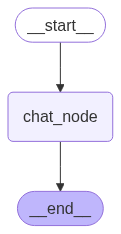

In [5]:
checkpointer = MemorySaver()
graph = StateGraph(ChatState)

# add nodes 
graph.add_node('chat_node',chat_node)

# add edge
graph.add_edge(START, 'chat_node')
graph.add_edge('chat_node', END)

chatbot = graph.compile(checkpointer=checkpointer)
chatbot

In [7]:
# initial_state = {
#     'message': [HumanMessage(content='what is the capital of India?')]
# }
# chatbot.invoke(initial_state)

In [8]:
thread_id = '1'

while True:
    user_msg = input("Type here: ")
    print("User:", user_msg)
    if user_msg.strip().lower() in ['exit', 'quit', 'bye']:
        break
    config={'configurable':{'thread_id':thread_id}}
    response = chatbot.invoke({'message':[HumanMessage(content=user_msg)]}, config=config)
    print("AI:", response['message'][-1].content)

Type here:  what is capital of USA?


User: what is capital of USA?


D:\LangGraph\.lang-graph\Lib\site-packages\langchain_google_genai\chat_models.py:357: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


AI: The capital of the USA is **Washington, D.C.**


Type here:  and China?


User: and China?


D:\LangGraph\.lang-graph\Lib\site-packages\langchain_google_genai\chat_models.py:357: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


AI: The capital of China is **Beijing**.


Type here:  and New Delhi?


User: and New Delhi?


D:\LangGraph\.lang-graph\Lib\site-packages\langchain_google_genai\chat_models.py:357: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


AI: New Delhi *is* the capital of India.


Type here:  bye


User: bye


In [12]:
chatbot.get_state(config=config)[0]

{'message': [HumanMessage(content='what is capital of USA?', additional_kwargs={}, response_metadata={}, id='4af99ff7-a35f-490b-9fd4-ed29e1f5d3a5'),
  AIMessage(content='The capital of the USA is **Washington, D.C.**', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--843fa5ce-44e5-43af-a8d2-956d053a12ed-0', usage_metadata={'input_tokens': 6, 'output_tokens': 14, 'total_tokens': 20, 'input_token_details': {'cache_read': 0}}),
  HumanMessage(content='and China?', additional_kwargs={}, response_metadata={}, id='2df9fc8f-585f-4511-911e-bba2efdfe8ed'),
  AIMessage(content='The capital of China is **Beijing**.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--e31ed995-1a09-4d2d-aa57-b45c49a0c3f0-0', usage_metadata={'input_tokens': 22, 'output_tokens': 9, 'total_tokens': 31

In [14]:
for i in chatbot.get_state_history(config=config):
    print(i)

StateSnapshot(values={'message': [HumanMessage(content='what is capital of USA?', additional_kwargs={}, response_metadata={}, id='4af99ff7-a35f-490b-9fd4-ed29e1f5d3a5'), AIMessage(content='The capital of the USA is **Washington, D.C.**', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--843fa5ce-44e5-43af-a8d2-956d053a12ed-0', usage_metadata={'input_tokens': 6, 'output_tokens': 14, 'total_tokens': 20, 'input_token_details': {'cache_read': 0}}), HumanMessage(content='and China?', additional_kwargs={}, response_metadata={}, id='2df9fc8f-585f-4511-911e-bba2efdfe8ed'), AIMessage(content='The capital of China is **Beijing**.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--e31ed995-1a09-4d2d-aa57-b45c49a0c3f0-0', usage_metadata={'input_tokens': 22, 'output_tokens': 9, 'to